In [1]:
from tensorflow.keras.optimizers import *
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks

from tensorflow.keras.models import load_model
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from keras.utils import Sequence

import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
X_train = np.load('/content/drive/My Drive/data/X_train2010-2013.npy', allow_pickle=True)
X_test = np.load('/content/drive/My Drive/data/X_test2014.npy', allow_pickle=True)
X_val = np.load('/content/drive/My Drive/data/X_val.npy',allow_pickle=True)

y_train = np.load('/content/drive/My Drive/data/y_train.npy', allow_pickle=True)
y_val = np.load('/content/drive/My Drive/data/y_val.npy', allow_pickle=True)
y_test = np.load('/content/drive/My Drive/data/y_test.npy', allow_pickle=True)

In [0]:
# shpY = (100,260) #
# shpX = (150,342) # 
# shpY = (122,282) #100-300
# shpX = (182,342) #150-350 
# shpY = (0,448) #
# shpX = (0,384) # 

# assert (shpX[1]-shpX[0])%32==0
# assert (shpY[1]-shpY[0])%32==0
X_val = np.load('/content/drive/My Drive/data/X_val.npy',allow_pickle=True)


In [7]:
def apply2dmask(array3d, mask2d):
    mask = np.broadcast_to(mask2d, array3d.shape)
    array3d[mask]=np.nan
    res = array3d
    return res
land_mask = np.load('/content/drive/My Drive/data/mask.npy', allow_pickle=True)

def preprocess_Xarray(array):
  for i in range(array.shape[-1]):
    array[:,:,:,i] = apply2dmask(array[:,:,:,i], land_mask)


  for i in range(array.shape[0]):
    for j in range(array.shape[-1]):
      array[i,:,:,j] = (array[i,:,:,j] - np.nanmean(array[i,:,:,j], axis=0))/np.nanstd(array[i,:,:,j], axis=0)
      
  padY = 32 - (array.shape[1] % 32)
  padX = 32 - (array.shape[2] % 32)
  array = np.pad(array, [(0,0),(0, padY), (0, padX),(0,0)], mode='constant', constant_values=np.nan)
  
  array[np.isnan(array)] = -1
  assert (array.shape[1])%32==0
  assert (array.shape[2])%32==0
  
  return array

X_train_proc = preprocess_Xarray(X_train)
X_test_proc = preprocess_Xarray(X_test)
X_val_proc = preprocess_Xarray(X_val)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [0]:
def preprocessYarray(array):
  array = apply2dmask(array[:,:,:,0], land_mask)

  padY = 32 - (array.shape[1] % 32)
  padX = 32 - (array.shape[2] % 32)
  array = np.pad(array, [(0,0),(0, padY), (0, padX)], mode='constant', constant_values=np.nan)
  array[np.isnan(array)] = -1
  return array[:,:,:,np.newaxis]
  
y_train_proc = preprocessYarray(y_train)
y_test_proc = preprocessYarray(y_test)
y_val_proc = preprocessYarray(y_val)


In [0]:
def rainnet(input_shape=(448, 384, 2), mode="regression"):
    """
    The function for building the RainNet (v1.0) model from scratch
    using Keras functional API.
    Parameters:
    input size: tuple(W x H x C), where W (width) and H (height)
    describe spatial dimensions of input data (e.g., 928x928 for RY data);
    and C (channels) describes temporal (depth) dimension of 
    input data (e.g., 4 means accounting four latest radar scans at time
    t-15, t-10, t-5 minutes, and t)
    
    mode: "regression" (default) or "segmentation". 
    For "regression" mode the last activation function is linear, 
    while for "segmentation" it is sigmoid.
    To train RainNet to predict continuous precipitation intensities use 
    "regression" mode. 
    RainNet could be trained to predict the exceedance of specific intensity 
    thresholds. For that purpose, use "segmentation" mode.
    """

    inputs = Input(input_shape)
    mask = Masking(mask_value=-1)(inputs)
    conv1f = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(mask)
    conv1f = Activation("relu")(conv1f)
    conv1s = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv1f)
    conv1s = Activation("relu")(conv1s)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1s)

    conv2f = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(pool1)
    conv2f = Activation("relu")(conv2f)
    conv2s = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv2f)
    conv2s = Activation("relu")(conv2s)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2s)

    conv3f = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(pool2)
    conv3f = Activation("relu")(conv3f)
    conv3s = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv3f)
    conv3s = Activation("relu")(conv3s)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3s)

    conv4f = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(pool3)
    conv4f = Activation("relu")(conv4f)
    conv4s = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv4f)
    conv4s = Activation("relu")(conv4s)
    drop4 = Dropout(0.5)(conv4s)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5f = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(pool4)
    conv5f = Activation("relu")(conv5f)
    conv5s = Conv2D(1024, 3, padding='same', kernel_initializer='he_normal')(conv5f)
    conv5s = Activation("relu")(conv5s)
    drop5 = Dropout(0.5)(conv5s)

    up6 = concatenate([UpSampling2D(size=(2, 2))(drop5), conv4s], axis=3)
    conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(up6)
    conv6 = Activation("relu")(conv6)
    conv6 = Conv2D(512, 3, padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = Activation("relu")(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3s], axis=3)
    conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(up7)
    conv7 = Activation("relu")(conv7)
    conv7 = Conv2D(256, 3, padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = Activation("relu")(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2s], axis=3)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(up8)
    conv8 = Activation("relu")(conv8)
    conv8 = Conv2D(128, 3, padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Activation("relu")(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1s], axis=3)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(up9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(64, 3, padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Activation("relu")(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    
    if mode == "regression":
        outputs = Conv2D(1, 1, activation='linear')(conv9)
    elif mode == "segmentation":
        outputs = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)

    return model

In [12]:
model = rainnet(input_shape=(X_train_proc.shape[1],X_train_proc.shape[2],X_train_proc.shape[-1]))
def root_mean_squared_error_masked(y_true, y_pred):
  # mask_value = K.variable(-1)
  # mask = K.all(K.equal(y_true, mask_value), axis=-1)
  # mask = 1 - K.cast(mask, K.floatx())
  
  y_true_masked = K.gather(error, K.where(K.not_equal(y_true, -1)))
  loss = K.sqrt(K.mean(K.square(y_pred - y_true_masked), axis=-1))
  return loss

def root_mean_squared_error(y_true, y_pred):
  loss = K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
  return loss

model.compile(optimizer=Adam(lr=1e-04), loss='logcosh', metrics = root_mean_squared_error)
hist = model.fit(x=X_train_proc,
               y=y_train_proc,
               validation_data=(X_val_proc,
                                y_val_proc),
               batch_size=4,
               epochs=25,
               callbacks=[callbacks.ModelCheckpoint('/content/drive/My Drive/data/model_fulldom_2.h5', save_best_only=True), 
                          PlotLossesKeras()])

Epoch 1/25
353/353 [==============================] - 151s 428ms/step - loss: 0.1981 - root_mean_squared_error: 0.4381 - val_loss: 0.1277 - val_root_mean_squared_error: 0.4107
Epoch 2/25
353/353 [==============================] - 147s 417ms/step - loss: 0.1288 - root_mean_squared_error: 0.2676 - val_loss: 0.1016 - val_root_mean_squared_error: 0.3259
Epoch 3/25
353/353 [==============================] - 147s 415ms/step - loss: 0.1221 - root_mean_squared_error: 0.2540 - val_loss: 0.0888 - val_root_mean_squared_error: 0.2694
Epoch 4/25
353/353 [==============================] - 143s 405ms/step - loss: 0.1174 - root_mean_squared_error: 0.2458 - val_loss: 0.1013 - val_root_mean_squared_error: 0.3290
Epoch 5/25
353/353 [==============================] - 147s 415ms/step - loss: 0.1148 - root_mean_squared_error: 0.2504 - val_loss: 0.0836 - val_root_mean_squared_error: 0.2562
Epoch 6/25
353/353 [==============================] - 146s 415ms/step - loss: 0.1101 - root_mean_squared_error: 0.2396 -

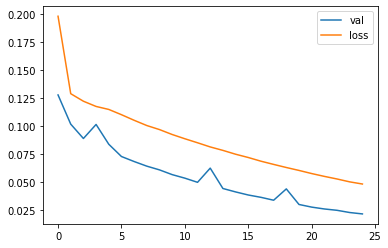

In [13]:
import matplotlib.pyplot as plt

plt.plot(hist.history['val_loss'],label='val')
plt.plot(hist.history['loss'],label='loss')
plt.legend()

In [0]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
def root_mean_squared_error(y_true, y_pred):
  loss = K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))
  return loss
model = load_model('/content/drive/My Drive/data/model_fulldom_3_continue_2.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error})

hist = model.fit(x=X_train_proc,
               y=y_train_proc,
               validation_data=(X_val_proc,
                                y_val_proc),
               batch_size=2,
               epochs=25,
               callbacks=[callbacks.ModelCheckpoint('/content/drive/My Drive/data/model_fulldom_3_continue_3.h5', save_best_only=True)])

Epoch 1/25
706/706 [==============================] - 153s 216ms/step - loss: 0.0060 - root_mean_squared_error: 0.0338 - val_loss: 0.0028 - val_root_mean_squared_error: 0.0345
Epoch 2/25
706/706 [==============================] - 149s 211ms/step - loss: 0.0062 - root_mean_squared_error: 0.0356 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0494
Epoch 3/25
706/706 [==============================] - 149s 211ms/step - loss: 0.0058 - root_mean_squared_error: 0.0340 - val_loss: 0.0034 - val_root_mean_squared_error: 0.0484
Epoch 4/25
706/706 [==============================] - 153s 217ms/step - loss: 0.0058 - root_mean_squared_error: 0.0344 - val_loss: 0.0027 - val_root_mean_squared_error: 0.0343
Epoch 5/25
706/706 [==============================] - 152s 215ms/step - loss: 0.0057 - root_mean_squared_error: 0.0345 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0326
Epoch 6/25
414/706 [================>.............] - ETA: 1:00 - loss: 0.0073 - root_mean_squared_error: 0.0378

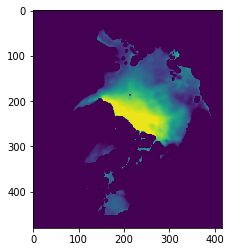

In [12]:
res = model.predict(X_test_proc[np.newaxis,10, :,:,:])
plt.imshow(res[0,:,:,0], vmin=0.5, vmax=2)

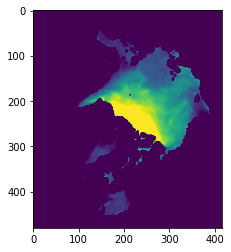

In [15]:
plt.imshow(y_test_proc[10,:,:,0], vmin=0.5, vmax=2)